In [425]:
import numpy as np
import pandas as pd
from collections import Counter
import nltk
import re
from string import punctuation
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud


In [711]:
# Others
import re
import nltk
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Sklearn library
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Keras library
import keras.backend as K
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional, GRU, SpatialDropout1D
from sklearn.metrics import f1_score
from keras.layers import  BatchNormalization

In [728]:
from keras.engine.topology import Layer
class Attention(Layer):
    def __init__(self, attention_size, **kwargs):
        self.attention_size = attention_size
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # W: (EMBED_SIZE, ATTENTION_SIZE)
        # b: (ATTENTION_SIZE, 1)
        # u: (ATTENTION_SIZE, 1)
        self.W = self.add_weight(name="W_{:s}".format(self.name),
                                 shape=(input_shape[-1], self.attention_size),
                                 initializer="glorot_normal",
                                 trainable=True)
        self.b = self.add_weight(name="b_{:s}".format(self.name),
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(name="u_{:s}".format(self.name),
                                 shape=(self.attention_size, 1),
                                 initializer="glorot_normal",
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x, mask=None):
        # input: (BATCH_SIZE, MAX_TIMESTEPS, EMBED_SIZE)
        # et: (BATCH_SIZE, MAX_TIMESTEPS, ATTENTION_SIZE)
        et = K.tanh(K.dot(x, self.W) + self.b)
        # at: (BATCH_SIZE, MAX_TIMESTEPS)
        at = K.softmax(K.squeeze(K.dot(et, self.u), axis=-1))
        if mask is not None:
            at *= K.cast(mask, K.floatx())
        # ot: (BATCH_SIZE, MAX_TIMESTEPS, EMBED_SIZE)
        atx = K.expand_dims(at, axis=-1)
        ot = atx * x
        # output: (BATCH_SIZE, EMBED_SIZE)
        output = K.sum(ot, axis=1)
        return output

    def compute_mask(self, input, input_mask=None):
        return None

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

#### Read data

In [466]:
train_data = pd.read_table("./project2_data/olid-training-v1.0.tsv", sep='\t')
train_data.drop(['id'], axis = 1, inplace = True)

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [467]:
labels_level_a= pd.read_csv('./project2_data/labels-levela.csv', header=None, names=['id', 'label_a'])
labels_level_b= pd.read_csv('./project2_data/labels-levelb.csv', header=None, names=['id', 'label_b'])
labels_level_c= pd.read_csv('./project2_data/labels-levelc.csv', header=None, names=['id', 'label_c'])

labels_level_a_dict = dict(zip(labels_level_a.id, labels_level_a.label_a))
labels_level_b_dict = dict(zip(labels_level_b.id, labels_level_b.label_b))
labels_level_c_dict = dict(zip(labels_level_c.id, labels_level_c.label_c))

In [468]:
test_data_a = pd.read_table("./project2_data/testset-levela.tsv", sep='\t')
test_data_b = pd.read_table("./project2_data/testset-levelb.tsv", sep='\t')
test_data_c = pd.read_table("./project2_data/testset-levelc.tsv", sep='\t')

/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.
/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  
/usr/local/Cellar/ipython/7.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [469]:
def labelizeTestData(test_data):
    test_data['subtask_a'] = test_data.apply(lambda row: labels_level_a_dict[row.id] if row.id in labels_level_a_dict else None, axis=1)
    test_data['subtask_b'] = test_data.apply(lambda row: labels_level_b_dict[row.id] if row.id in labels_level_b_dict else None, axis=1)
    test_data['subtask_c'] = test_data.apply(lambda row: labels_level_c_dict[row.id] if row.id in labels_level_c_dict else None, axis=1)
    test_data.drop(['id'], axis = 1, inplace = True)
    return test_data

In [470]:
test_data_a = labelizeTestData(test_data_a)
test_data_b = labelizeTestData(test_data_b)
test_data_c = labelizeTestData(test_data_c)

In [471]:
overall_dataset = pd.concat([train_data, test_data_a, test_data_b, test_data_c])
overall_dataset.reset_index(drop=True, inplace=True)
print(overall_dataset['subtask_a'].value_counts())
print(overall_dataset['subtask_b'].value_counts())
print(overall_dataset['subtask_c'].value_counts())

NOT    9460
OFF    5093
Name: subtask_a, dtype: int64
TIN    4515
UNT     578
Name: subtask_b, dtype: int64
IND    2707
GRP    1308
OTH     500
Name: subtask_c, dtype: int64


In [472]:
overall_dataset.head()

,tweet,subtask_a,subtask_b,subtask_c
0,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


#### Data preprocessing

In [485]:
overall_dataset_task_a = pd.concat([train_data, test_data_a])
overall_dataset_task_b = pd.concat([train_data, test_data_b])
overall_dataset_task_c = pd.concat([train_data, test_data_c])

In [484]:
print(len(overall_dataset_task_a))
print(len(overall_dataset_task_b))
print(len(overall_dataset_task_c))

14100
13480
13453


In [487]:
def getTrainDataIdx(train_data, task):
    train_data_copy = train_data.copy()
    train_data_copy.dropna(subset = [task], inplace = True, axis = 0)
    return len(train_data_copy)

In [488]:
train_data_task_a_idx = getTrainDataIdx(train_data, 'subtask_a')
train_data_task_b_idx = getTrainDataIdx(train_data, 'subtask_b')
train_data_task_c_idx = getTrainDataIdx(train_data, 'subtask_c')

In [490]:
print(train_data_task_a_idx)
print(train_data_task_b_idx)
print(train_data_task_c_idx)

13240
4400
3876


In [491]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import symspell_python as spell_checkers

In [494]:
cDict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cDict.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cDict[match.group(0)]
    return c_re.sub(replace, text)

In [495]:
def dataPreprocessing(dataset, task):
    dataset.dropna(subset = [task], inplace = True, axis = 0)
    dataset['raw_tweet'] = dataset['tweet']
    dataset['tweet'] = dataset['tweet'].apply(lambda x: x.replace("’","'")) 
    dataset['tweet'] = dataset['tweet'].apply(lambda x: expandContractions(x))
    dataset['tweet'] = dataset['tweet'].apply(lambda x: x.lower())
    #remove url, hashtags
    dataset['tweet'] = dataset['tweet'].apply(lambda x: ' '.join(re.sub(r"(@[A-Za-z0-9]+)|^rt |(#[A-Za-z0-9]+) |(\w+:\/*\S+)|[^a-zA-Z\s]","",x).split()))
    dataset['tweet'] = dataset['tweet'].apply(lambda x: x.replace('url',''))
    # lemmatisation
    tokeniser = TweetTokenizer()
    wordnet_lemmatizer = WordNetLemmatizer()
    dataset['tweet'] = dataset['tweet'].apply(lambda x: [word for word in tokeniser.tokenize(x)])
    
        #spell check
    spell_checkers.create_dictionary("./eng_dict.txt")
    print("Perform spell checking...")
    for i in range(len(dataset['tweet'])):
        try:
            print('%i out of %i' % (i, len(dataset['tweet'])))
            for j in range(len(dataset['tweet'][i])):
                suggs = spell_checkers.get_suggestions(dataset['tweet'][i][j])
                if suggs:
                    best_sugg = str(suggs[0])
                    dataset['tweet'][i][j] = best_sugg
        except:
            continue
            
    dataset['tweet'] = dataset['tweet'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word, pos = "v") for word in x]))
    
    return dataset
    

In [496]:
dataset_task_a = dataPreprocessing(overall_dataset_task_a, 'subtask_a')
dataset_task_a.head()

Creating dictionary...
total words processed: 223118
total unique words in corpus: 223118
total items in dictionary (corpus words and deletions): 6778287
  edit distance for deletions: 3
  length of longest word in corpus: 15
Perform spell checking...
0 out of 14100
1 out of 14100
2 out of 14100
3 out of 14100
4 out of 14100
5 out of 14100
6 out of 14100
7 out of 14100
8 out of 14100
9 out of 14100
10 out of 14100
11 out of 14100
12 out of 14100
13 out of 14100
14 out of 14100
15 out of 14100
16 out of 14100
17 out of 14100
18 out of 14100
19 out of 14100
20 out of 14100
21 out of 14100
22 out of 14100
23 out of 14100
24 out of 14100
25 out of 14100
26 out of 14100
27 out of 14100
28 out of 14100
29 out of 14100
30 out of 14100
31 out of 14100
32 out of 14100
33 out of 14100
34 out of 14100
35 out of 14100
36 out of 14100
37 out of 14100
38 out of 14100
39 out of 14100
40 out of 14100
41 out of 14100
42 out of 14100
43 out of 14100
44 out of 14100
45 out of 14100
46 out of 14100
47 out

509 out of 14100
510 out of 14100
511 out of 14100
512 out of 14100
513 out of 14100
514 out of 14100
515 out of 14100
516 out of 14100
517 out of 14100
518 out of 14100
519 out of 14100
520 out of 14100
521 out of 14100
522 out of 14100
523 out of 14100
524 out of 14100
525 out of 14100
526 out of 14100
527 out of 14100
528 out of 14100
529 out of 14100
530 out of 14100
531 out of 14100
532 out of 14100
533 out of 14100
534 out of 14100
535 out of 14100
536 out of 14100
537 out of 14100
538 out of 14100
539 out of 14100
540 out of 14100
541 out of 14100
542 out of 14100
543 out of 14100
544 out of 14100
545 out of 14100
546 out of 14100
547 out of 14100
548 out of 14100
549 out of 14100
550 out of 14100
551 out of 14100
552 out of 14100
553 out of 14100
554 out of 14100
555 out of 14100
556 out of 14100
557 out of 14100
558 out of 14100
559 out of 14100
560 out of 14100
561 out of 14100
562 out of 14100
563 out of 14100
564 out of 14100
565 out of 14100
566 out of 14100
567 out of 141

990 out of 14100
991 out of 14100
992 out of 14100
993 out of 14100
994 out of 14100
995 out of 14100
996 out of 14100
997 out of 14100
998 out of 14100
999 out of 14100
1000 out of 14100
1001 out of 14100
1002 out of 14100
1003 out of 14100
1004 out of 14100
1005 out of 14100
1006 out of 14100
1007 out of 14100
1008 out of 14100
1009 out of 14100
1010 out of 14100
1011 out of 14100
1012 out of 14100
1013 out of 14100
1014 out of 14100
1015 out of 14100
1016 out of 14100
1017 out of 14100
1018 out of 14100
1019 out of 14100
1020 out of 14100
1021 out of 14100
1022 out of 14100
1023 out of 14100
1024 out of 14100
1025 out of 14100
1026 out of 14100
1027 out of 14100
1028 out of 14100
1029 out of 14100
1030 out of 14100
1031 out of 14100
1032 out of 14100
1033 out of 14100
1034 out of 14100
1035 out of 14100
1036 out of 14100
1037 out of 14100
1038 out of 14100
1039 out of 14100
1040 out of 14100
1041 out of 14100
1042 out of 14100
1043 out of 14100
1044 out of 14100
1045 out of 14100
10

1433 out of 14100
1434 out of 14100
1435 out of 14100
1436 out of 14100
1437 out of 14100
1438 out of 14100
1439 out of 14100
1440 out of 14100
1441 out of 14100
1442 out of 14100
1443 out of 14100
1444 out of 14100
1445 out of 14100
1446 out of 14100
1447 out of 14100
1448 out of 14100
1449 out of 14100
1450 out of 14100
1451 out of 14100
1452 out of 14100
1453 out of 14100
1454 out of 14100
1455 out of 14100
1456 out of 14100
1457 out of 14100
1458 out of 14100
1459 out of 14100
1460 out of 14100
1461 out of 14100
1462 out of 14100
1463 out of 14100
1464 out of 14100
1465 out of 14100
1466 out of 14100
1467 out of 14100
1468 out of 14100
1469 out of 14100
1470 out of 14100
1471 out of 14100
1472 out of 14100
1473 out of 14100
1474 out of 14100
1475 out of 14100
1476 out of 14100
1477 out of 14100
1478 out of 14100
1479 out of 14100
1480 out of 14100
1481 out of 14100
1482 out of 14100
1483 out of 14100
1484 out of 14100
1485 out of 14100
1486 out of 14100
1487 out of 14100
1488 out o

1895 out of 14100
1896 out of 14100
1897 out of 14100
1898 out of 14100
no items in dictionary within maximum edit distance
1899 out of 14100
1900 out of 14100
1901 out of 14100
1902 out of 14100
1903 out of 14100
1904 out of 14100
1905 out of 14100
1906 out of 14100
1907 out of 14100
1908 out of 14100
1909 out of 14100
1910 out of 14100
1911 out of 14100
1912 out of 14100
1913 out of 14100
1914 out of 14100
1915 out of 14100
1916 out of 14100
1917 out of 14100
1918 out of 14100
1919 out of 14100
1920 out of 14100
1921 out of 14100
1922 out of 14100
1923 out of 14100
1924 out of 14100
1925 out of 14100
1926 out of 14100
1927 out of 14100
1928 out of 14100
1929 out of 14100
1930 out of 14100
1931 out of 14100
1932 out of 14100
1933 out of 14100
1934 out of 14100
1935 out of 14100
1936 out of 14100
1937 out of 14100
1938 out of 14100
1939 out of 14100
1940 out of 14100
1941 out of 14100
1942 out of 14100
1943 out of 14100
1944 out of 14100
1945 out of 14100
1946 out of 14100
1947 out of 

2352 out of 14100
2353 out of 14100
2354 out of 14100
2355 out of 14100
2356 out of 14100
2357 out of 14100
2358 out of 14100
2359 out of 14100
2360 out of 14100
2361 out of 14100
2362 out of 14100
2363 out of 14100
2364 out of 14100
2365 out of 14100
2366 out of 14100
2367 out of 14100
2368 out of 14100
2369 out of 14100
2370 out of 14100
2371 out of 14100
2372 out of 14100
2373 out of 14100
2374 out of 14100
2375 out of 14100
2376 out of 14100
2377 out of 14100
2378 out of 14100
2379 out of 14100
2380 out of 14100
2381 out of 14100
2382 out of 14100
2383 out of 14100
2384 out of 14100
2385 out of 14100
2386 out of 14100
2387 out of 14100
2388 out of 14100
2389 out of 14100
2390 out of 14100
2391 out of 14100
2392 out of 14100
2393 out of 14100
2394 out of 14100
2395 out of 14100
2396 out of 14100
2397 out of 14100
2398 out of 14100
2399 out of 14100
2400 out of 14100
2401 out of 14100
2402 out of 14100
2403 out of 14100
2404 out of 14100
2405 out of 14100
2406 out of 14100
2407 out o

2804 out of 14100
2805 out of 14100
2806 out of 14100
2807 out of 14100
2808 out of 14100
2809 out of 14100
2810 out of 14100
2811 out of 14100
2812 out of 14100
2813 out of 14100
2814 out of 14100
2815 out of 14100
2816 out of 14100
2817 out of 14100
2818 out of 14100
2819 out of 14100
2820 out of 14100
2821 out of 14100
2822 out of 14100
2823 out of 14100
2824 out of 14100
2825 out of 14100
2826 out of 14100
2827 out of 14100
2828 out of 14100
2829 out of 14100
2830 out of 14100
2831 out of 14100
2832 out of 14100
2833 out of 14100
2834 out of 14100
2835 out of 14100
2836 out of 14100
2837 out of 14100
2838 out of 14100
2839 out of 14100
2840 out of 14100
2841 out of 14100
2842 out of 14100
2843 out of 14100
2844 out of 14100
2845 out of 14100
2846 out of 14100
2847 out of 14100
2848 out of 14100
2849 out of 14100
2850 out of 14100
2851 out of 14100
2852 out of 14100
2853 out of 14100
2854 out of 14100
2855 out of 14100
2856 out of 14100
2857 out of 14100
2858 out of 14100
2859 out o

3252 out of 14100
3253 out of 14100
3254 out of 14100
3255 out of 14100
3256 out of 14100
3257 out of 14100
3258 out of 14100
3259 out of 14100
3260 out of 14100
3261 out of 14100
3262 out of 14100
3263 out of 14100
3264 out of 14100
3265 out of 14100
3266 out of 14100
3267 out of 14100
3268 out of 14100
3269 out of 14100
3270 out of 14100
3271 out of 14100
3272 out of 14100
3273 out of 14100
3274 out of 14100
3275 out of 14100
3276 out of 14100
3277 out of 14100
3278 out of 14100
3279 out of 14100
3280 out of 14100
3281 out of 14100
3282 out of 14100
3283 out of 14100
3284 out of 14100
3285 out of 14100
3286 out of 14100
3287 out of 14100
3288 out of 14100
3289 out of 14100
3290 out of 14100
3291 out of 14100
3292 out of 14100
3293 out of 14100
3294 out of 14100
3295 out of 14100
3296 out of 14100
3297 out of 14100
3298 out of 14100
3299 out of 14100
3300 out of 14100
3301 out of 14100
3302 out of 14100
3303 out of 14100
3304 out of 14100
3305 out of 14100
3306 out of 14100
3307 out o

3701 out of 14100
3702 out of 14100
3703 out of 14100
3704 out of 14100
3705 out of 14100
3706 out of 14100
3707 out of 14100
3708 out of 14100
3709 out of 14100
3710 out of 14100
3711 out of 14100
3712 out of 14100
3713 out of 14100
3714 out of 14100
3715 out of 14100
3716 out of 14100
3717 out of 14100
3718 out of 14100
3719 out of 14100
3720 out of 14100
3721 out of 14100
3722 out of 14100
3723 out of 14100
3724 out of 14100
3725 out of 14100
3726 out of 14100
3727 out of 14100
3728 out of 14100
3729 out of 14100
3730 out of 14100
3731 out of 14100
3732 out of 14100
3733 out of 14100
3734 out of 14100
3735 out of 14100
no items in dictionary within maximum edit distance
3736 out of 14100
3737 out of 14100
3738 out of 14100
3739 out of 14100
3740 out of 14100
3741 out of 14100
3742 out of 14100
3743 out of 14100
3744 out of 14100
3745 out of 14100
3746 out of 14100
3747 out of 14100
3748 out of 14100
3749 out of 14100
3750 out of 14100
3751 out of 14100
3752 out of 14100
3753 out of 

4152 out of 14100
4153 out of 14100
4154 out of 14100
4155 out of 14100
4156 out of 14100
4157 out of 14100
4158 out of 14100
no items in dictionary within maximum edit distance
4159 out of 14100
4160 out of 14100
4161 out of 14100
4162 out of 14100
4163 out of 14100
4164 out of 14100
4165 out of 14100
4166 out of 14100
4167 out of 14100
4168 out of 14100
4169 out of 14100
4170 out of 14100
4171 out of 14100
4172 out of 14100
4173 out of 14100
4174 out of 14100
4175 out of 14100
4176 out of 14100
4177 out of 14100
4178 out of 14100
4179 out of 14100
4180 out of 14100
4181 out of 14100
4182 out of 14100
4183 out of 14100
no items in dictionary within maximum edit distance
4184 out of 14100
4185 out of 14100
4186 out of 14100
4187 out of 14100
4188 out of 14100
4189 out of 14100
4190 out of 14100
4191 out of 14100
4192 out of 14100
4193 out of 14100
4194 out of 14100
4195 out of 14100
4196 out of 14100
4197 out of 14100
4198 out of 14100
4199 out of 14100
4200 out of 14100
4201 out of 14

4589 out of 14100
4590 out of 14100
4591 out of 14100
4592 out of 14100
4593 out of 14100
4594 out of 14100
4595 out of 14100
4596 out of 14100
4597 out of 14100
4598 out of 14100
4599 out of 14100
4600 out of 14100
4601 out of 14100
4602 out of 14100
4603 out of 14100
4604 out of 14100
4605 out of 14100
4606 out of 14100
4607 out of 14100
4608 out of 14100
4609 out of 14100
4610 out of 14100
4611 out of 14100
4612 out of 14100
4613 out of 14100
4614 out of 14100
4615 out of 14100
4616 out of 14100
4617 out of 14100
4618 out of 14100
4619 out of 14100
4620 out of 14100
4621 out of 14100
4622 out of 14100
4623 out of 14100
4624 out of 14100
4625 out of 14100
4626 out of 14100
4627 out of 14100
4628 out of 14100
4629 out of 14100
4630 out of 14100
4631 out of 14100
4632 out of 14100
4633 out of 14100
4634 out of 14100
4635 out of 14100
4636 out of 14100
4637 out of 14100
4638 out of 14100
4639 out of 14100
4640 out of 14100
4641 out of 14100
4642 out of 14100
4643 out of 14100
4644 out o

5042 out of 14100
5043 out of 14100
5044 out of 14100
5045 out of 14100
5046 out of 14100
5047 out of 14100
5048 out of 14100
5049 out of 14100
5050 out of 14100
5051 out of 14100
5052 out of 14100
5053 out of 14100
5054 out of 14100
5055 out of 14100
5056 out of 14100
5057 out of 14100
5058 out of 14100
no items in dictionary within maximum edit distance
5059 out of 14100
5060 out of 14100
5061 out of 14100
5062 out of 14100
5063 out of 14100
5064 out of 14100
5065 out of 14100
5066 out of 14100
5067 out of 14100
5068 out of 14100
5069 out of 14100
5070 out of 14100
5071 out of 14100
5072 out of 14100
5073 out of 14100
5074 out of 14100
5075 out of 14100
5076 out of 14100
5077 out of 14100
5078 out of 14100
5079 out of 14100
5080 out of 14100
5081 out of 14100
5082 out of 14100
5083 out of 14100
5084 out of 14100
5085 out of 14100
5086 out of 14100
5087 out of 14100
5088 out of 14100
5089 out of 14100
5090 out of 14100
5091 out of 14100
5092 out of 14100
5093 out of 14100
5094 out of 

5483 out of 14100
5484 out of 14100
5485 out of 14100
5486 out of 14100
5487 out of 14100
5488 out of 14100
5489 out of 14100
5490 out of 14100
5491 out of 14100
5492 out of 14100
5493 out of 14100
5494 out of 14100
5495 out of 14100
5496 out of 14100
5497 out of 14100
5498 out of 14100
5499 out of 14100
5500 out of 14100
5501 out of 14100
5502 out of 14100
5503 out of 14100
5504 out of 14100
5505 out of 14100
5506 out of 14100
5507 out of 14100
5508 out of 14100
5509 out of 14100
5510 out of 14100
5511 out of 14100
5512 out of 14100
5513 out of 14100
5514 out of 14100
5515 out of 14100
5516 out of 14100
5517 out of 14100
5518 out of 14100
5519 out of 14100
5520 out of 14100
5521 out of 14100
5522 out of 14100
5523 out of 14100
5524 out of 14100
no items in dictionary within maximum edit distance
5525 out of 14100
5526 out of 14100
5527 out of 14100
5528 out of 14100
5529 out of 14100
5530 out of 14100
5531 out of 14100
5532 out of 14100
5533 out of 14100
5534 out of 14100
5535 out of 

5928 out of 14100
5929 out of 14100
5930 out of 14100
5931 out of 14100
5932 out of 14100
5933 out of 14100
5934 out of 14100
5935 out of 14100
5936 out of 14100
5937 out of 14100
5938 out of 14100
5939 out of 14100
5940 out of 14100
5941 out of 14100
5942 out of 14100
5943 out of 14100
5944 out of 14100
5945 out of 14100
5946 out of 14100
5947 out of 14100
5948 out of 14100
5949 out of 14100
5950 out of 14100
no items in dictionary within maximum edit distance
5951 out of 14100
5952 out of 14100
5953 out of 14100
5954 out of 14100
5955 out of 14100
5956 out of 14100
5957 out of 14100
5958 out of 14100
5959 out of 14100
5960 out of 14100
5961 out of 14100
5962 out of 14100
5963 out of 14100
5964 out of 14100
5965 out of 14100
5966 out of 14100
5967 out of 14100
5968 out of 14100
5969 out of 14100
no items in dictionary within maximum edit distance
5970 out of 14100
5971 out of 14100
5972 out of 14100
5973 out of 14100
5974 out of 14100
5975 out of 14100
5976 out of 14100
5977 out of 14

6384 out of 14100
6385 out of 14100
6386 out of 14100
6387 out of 14100
6388 out of 14100
6389 out of 14100
6390 out of 14100
6391 out of 14100
6392 out of 14100
6393 out of 14100
6394 out of 14100
6395 out of 14100
6396 out of 14100
6397 out of 14100
6398 out of 14100
6399 out of 14100
6400 out of 14100
6401 out of 14100
6402 out of 14100
6403 out of 14100
6404 out of 14100
6405 out of 14100
6406 out of 14100
6407 out of 14100
6408 out of 14100
6409 out of 14100
6410 out of 14100
6411 out of 14100
6412 out of 14100
6413 out of 14100
6414 out of 14100
6415 out of 14100
6416 out of 14100
6417 out of 14100
6418 out of 14100
6419 out of 14100
6420 out of 14100
6421 out of 14100
6422 out of 14100
6423 out of 14100
6424 out of 14100
6425 out of 14100
6426 out of 14100
6427 out of 14100
6428 out of 14100
6429 out of 14100
6430 out of 14100
6431 out of 14100
6432 out of 14100
6433 out of 14100
6434 out of 14100
6435 out of 14100
6436 out of 14100
6437 out of 14100
6438 out of 14100
6439 out o

6842 out of 14100
6843 out of 14100
6844 out of 14100
6845 out of 14100
6846 out of 14100
6847 out of 14100
6848 out of 14100
6849 out of 14100
6850 out of 14100
6851 out of 14100
6852 out of 14100
6853 out of 14100
6854 out of 14100
6855 out of 14100
6856 out of 14100
6857 out of 14100
6858 out of 14100
6859 out of 14100
6860 out of 14100
6861 out of 14100
6862 out of 14100
6863 out of 14100
6864 out of 14100
6865 out of 14100
6866 out of 14100
6867 out of 14100
6868 out of 14100
6869 out of 14100
6870 out of 14100
6871 out of 14100
6872 out of 14100
6873 out of 14100
6874 out of 14100
6875 out of 14100
6876 out of 14100
6877 out of 14100
6878 out of 14100
6879 out of 14100
6880 out of 14100
6881 out of 14100
6882 out of 14100
6883 out of 14100
6884 out of 14100
6885 out of 14100
6886 out of 14100
6887 out of 14100
6888 out of 14100
6889 out of 14100
6890 out of 14100
6891 out of 14100
6892 out of 14100
6893 out of 14100
no items in dictionary within maximum edit distance
6894 out of 

7282 out of 14100
7283 out of 14100
7284 out of 14100
7285 out of 14100
7286 out of 14100
no items in dictionary within maximum edit distance
7287 out of 14100
7288 out of 14100
7289 out of 14100
7290 out of 14100
7291 out of 14100
7292 out of 14100
7293 out of 14100
7294 out of 14100
7295 out of 14100
7296 out of 14100
7297 out of 14100
7298 out of 14100
7299 out of 14100
7300 out of 14100
7301 out of 14100
7302 out of 14100
7303 out of 14100
7304 out of 14100
7305 out of 14100
7306 out of 14100
7307 out of 14100
7308 out of 14100
7309 out of 14100
7310 out of 14100
7311 out of 14100
7312 out of 14100
7313 out of 14100
7314 out of 14100
7315 out of 14100
7316 out of 14100
7317 out of 14100
7318 out of 14100
7319 out of 14100
7320 out of 14100
7321 out of 14100
7322 out of 14100
7323 out of 14100
7324 out of 14100
7325 out of 14100
7326 out of 14100
7327 out of 14100
7328 out of 14100
7329 out of 14100
7330 out of 14100
7331 out of 14100
7332 out of 14100
7333 out of 14100
7334 out of 

7725 out of 14100
7726 out of 14100
7727 out of 14100
7728 out of 14100
7729 out of 14100
7730 out of 14100
7731 out of 14100
7732 out of 14100
7733 out of 14100
7734 out of 14100
7735 out of 14100
7736 out of 14100
7737 out of 14100
7738 out of 14100
7739 out of 14100
7740 out of 14100
7741 out of 14100
7742 out of 14100
7743 out of 14100
7744 out of 14100
7745 out of 14100
7746 out of 14100
7747 out of 14100
7748 out of 14100
7749 out of 14100
7750 out of 14100
7751 out of 14100
7752 out of 14100
7753 out of 14100
7754 out of 14100
7755 out of 14100
7756 out of 14100
7757 out of 14100
7758 out of 14100
7759 out of 14100
7760 out of 14100
7761 out of 14100
7762 out of 14100
7763 out of 14100
7764 out of 14100
no items in dictionary within maximum edit distance
7765 out of 14100
7766 out of 14100
7767 out of 14100
7768 out of 14100
7769 out of 14100
7770 out of 14100
7771 out of 14100
7772 out of 14100
7773 out of 14100
7774 out of 14100
7775 out of 14100
7776 out of 14100
7777 out of 

8173 out of 14100
8174 out of 14100
8175 out of 14100
8176 out of 14100
8177 out of 14100
8178 out of 14100
8179 out of 14100
8180 out of 14100
8181 out of 14100
8182 out of 14100
8183 out of 14100
8184 out of 14100
8185 out of 14100
8186 out of 14100
8187 out of 14100
8188 out of 14100
8189 out of 14100
8190 out of 14100
8191 out of 14100
8192 out of 14100
8193 out of 14100
no items in dictionary within maximum edit distance
8194 out of 14100
8195 out of 14100
8196 out of 14100
8197 out of 14100
8198 out of 14100
8199 out of 14100
8200 out of 14100
8201 out of 14100
8202 out of 14100
8203 out of 14100
8204 out of 14100
8205 out of 14100
8206 out of 14100
8207 out of 14100
8208 out of 14100
8209 out of 14100
8210 out of 14100
8211 out of 14100
8212 out of 14100
8213 out of 14100
8214 out of 14100
8215 out of 14100
8216 out of 14100
8217 out of 14100
8218 out of 14100
8219 out of 14100
8220 out of 14100
8221 out of 14100
8222 out of 14100
8223 out of 14100
8224 out of 14100
8225 out of 

8623 out of 14100
8624 out of 14100
8625 out of 14100
8626 out of 14100
8627 out of 14100
8628 out of 14100
8629 out of 14100
8630 out of 14100
8631 out of 14100
8632 out of 14100
8633 out of 14100
8634 out of 14100
8635 out of 14100
8636 out of 14100
8637 out of 14100
8638 out of 14100
8639 out of 14100
8640 out of 14100
8641 out of 14100
8642 out of 14100
8643 out of 14100
8644 out of 14100
8645 out of 14100
8646 out of 14100
8647 out of 14100
8648 out of 14100
8649 out of 14100
8650 out of 14100
8651 out of 14100
8652 out of 14100
8653 out of 14100
8654 out of 14100
8655 out of 14100
8656 out of 14100
8657 out of 14100
8658 out of 14100
8659 out of 14100
8660 out of 14100
8661 out of 14100
8662 out of 14100
8663 out of 14100
8664 out of 14100
8665 out of 14100
8666 out of 14100
8667 out of 14100
8668 out of 14100
8669 out of 14100
8670 out of 14100
8671 out of 14100
8672 out of 14100
8673 out of 14100
8674 out of 14100
8675 out of 14100
8676 out of 14100
8677 out of 14100
8678 out o

9061 out of 14100
9062 out of 14100
9063 out of 14100
9064 out of 14100
9065 out of 14100
9066 out of 14100
9067 out of 14100
9068 out of 14100
9069 out of 14100
9070 out of 14100
9071 out of 14100
9072 out of 14100
9073 out of 14100
9074 out of 14100
9075 out of 14100
9076 out of 14100
9077 out of 14100
9078 out of 14100
9079 out of 14100
9080 out of 14100
9081 out of 14100
9082 out of 14100
9083 out of 14100
9084 out of 14100
9085 out of 14100
9086 out of 14100
9087 out of 14100
9088 out of 14100
9089 out of 14100
9090 out of 14100
9091 out of 14100
9092 out of 14100
9093 out of 14100
9094 out of 14100
9095 out of 14100
9096 out of 14100
9097 out of 14100
9098 out of 14100
9099 out of 14100
9100 out of 14100
9101 out of 14100
9102 out of 14100
9103 out of 14100
9104 out of 14100
9105 out of 14100
9106 out of 14100
9107 out of 14100
9108 out of 14100
9109 out of 14100
9110 out of 14100
9111 out of 14100
9112 out of 14100
9113 out of 14100
9114 out of 14100
9115 out of 14100
9116 out o

9506 out of 14100
9507 out of 14100
9508 out of 14100
9509 out of 14100
9510 out of 14100
9511 out of 14100
9512 out of 14100
9513 out of 14100
9514 out of 14100
9515 out of 14100
9516 out of 14100
9517 out of 14100
9518 out of 14100
9519 out of 14100
9520 out of 14100
9521 out of 14100
9522 out of 14100
9523 out of 14100
9524 out of 14100
9525 out of 14100
9526 out of 14100
9527 out of 14100
9528 out of 14100
9529 out of 14100
9530 out of 14100
9531 out of 14100
9532 out of 14100
9533 out of 14100
9534 out of 14100
9535 out of 14100
9536 out of 14100
9537 out of 14100
9538 out of 14100
9539 out of 14100
9540 out of 14100
9541 out of 14100
9542 out of 14100
9543 out of 14100
9544 out of 14100
9545 out of 14100
9546 out of 14100
9547 out of 14100
9548 out of 14100
9549 out of 14100
9550 out of 14100
9551 out of 14100
9552 out of 14100
9553 out of 14100
9554 out of 14100
9555 out of 14100
9556 out of 14100
9557 out of 14100
9558 out of 14100
9559 out of 14100
9560 out of 14100
9561 out o

9956 out of 14100
9957 out of 14100
9958 out of 14100
9959 out of 14100
9960 out of 14100
9961 out of 14100
9962 out of 14100
9963 out of 14100
9964 out of 14100
9965 out of 14100
9966 out of 14100
9967 out of 14100
9968 out of 14100
9969 out of 14100
9970 out of 14100
9971 out of 14100
9972 out of 14100
9973 out of 14100
9974 out of 14100
9975 out of 14100
9976 out of 14100
9977 out of 14100
9978 out of 14100
9979 out of 14100
9980 out of 14100
9981 out of 14100
9982 out of 14100
9983 out of 14100
9984 out of 14100
9985 out of 14100
9986 out of 14100
9987 out of 14100
9988 out of 14100
9989 out of 14100
9990 out of 14100
9991 out of 14100
9992 out of 14100
9993 out of 14100
9994 out of 14100
9995 out of 14100
no items in dictionary within maximum edit distance
9996 out of 14100
9997 out of 14100
9998 out of 14100
9999 out of 14100
10000 out of 14100
10001 out of 14100
10002 out of 14100
10003 out of 14100
10004 out of 14100
10005 out of 14100
10006 out of 14100
10007 out of 14100
1000

10376 out of 14100
10377 out of 14100
10378 out of 14100
10379 out of 14100
10380 out of 14100
10381 out of 14100
10382 out of 14100
10383 out of 14100
10384 out of 14100
10385 out of 14100
10386 out of 14100
10387 out of 14100
10388 out of 14100
10389 out of 14100
10390 out of 14100
10391 out of 14100
10392 out of 14100
10393 out of 14100
10394 out of 14100
no items in dictionary within maximum edit distance
10395 out of 14100
10396 out of 14100
10397 out of 14100
10398 out of 14100
10399 out of 14100
10400 out of 14100
10401 out of 14100
10402 out of 14100
10403 out of 14100
10404 out of 14100
10405 out of 14100
10406 out of 14100
10407 out of 14100
10408 out of 14100
10409 out of 14100
10410 out of 14100
10411 out of 14100
10412 out of 14100
10413 out of 14100
10414 out of 14100
10415 out of 14100
10416 out of 14100
10417 out of 14100
10418 out of 14100
10419 out of 14100
10420 out of 14100
10421 out of 14100
10422 out of 14100
10423 out of 14100
10424 out of 14100
10425 out of 1410

10793 out of 14100
10794 out of 14100
10795 out of 14100
10796 out of 14100
10797 out of 14100
10798 out of 14100
10799 out of 14100
10800 out of 14100
10801 out of 14100
10802 out of 14100
10803 out of 14100
10804 out of 14100
10805 out of 14100
10806 out of 14100
10807 out of 14100
10808 out of 14100
10809 out of 14100
10810 out of 14100
10811 out of 14100
10812 out of 14100
10813 out of 14100
10814 out of 14100
10815 out of 14100
10816 out of 14100
10817 out of 14100
10818 out of 14100
10819 out of 14100
10820 out of 14100
10821 out of 14100
10822 out of 14100
10823 out of 14100
10824 out of 14100
10825 out of 14100
10826 out of 14100
10827 out of 14100
10828 out of 14100
10829 out of 14100
10830 out of 14100
10831 out of 14100
10832 out of 14100
10833 out of 14100
10834 out of 14100
10835 out of 14100
10836 out of 14100
10837 out of 14100
10838 out of 14100
10839 out of 14100
10840 out of 14100
10841 out of 14100
10842 out of 14100
10843 out of 14100
10844 out of 14100
10845 out of

11222 out of 14100
11223 out of 14100
11224 out of 14100
11225 out of 14100
11226 out of 14100
11227 out of 14100
11228 out of 14100
11229 out of 14100
11230 out of 14100
11231 out of 14100
11232 out of 14100
11233 out of 14100
11234 out of 14100
11235 out of 14100
11236 out of 14100
11237 out of 14100
11238 out of 14100
11239 out of 14100
11240 out of 14100
11241 out of 14100
11242 out of 14100
11243 out of 14100
11244 out of 14100
11245 out of 14100
11246 out of 14100
11247 out of 14100
11248 out of 14100
11249 out of 14100
11250 out of 14100
11251 out of 14100
11252 out of 14100
11253 out of 14100
11254 out of 14100
11255 out of 14100
11256 out of 14100
11257 out of 14100
11258 out of 14100
11259 out of 14100
11260 out of 14100
11261 out of 14100
11262 out of 14100
11263 out of 14100
11264 out of 14100
11265 out of 14100
11266 out of 14100
11267 out of 14100
11268 out of 14100
11269 out of 14100
11270 out of 14100
11271 out of 14100
11272 out of 14100
11273 out of 14100
11274 out of

11651 out of 14100
11652 out of 14100
11653 out of 14100
11654 out of 14100
11655 out of 14100
11656 out of 14100
11657 out of 14100
11658 out of 14100
11659 out of 14100
11660 out of 14100
11661 out of 14100
11662 out of 14100
11663 out of 14100
11664 out of 14100
11665 out of 14100
11666 out of 14100
11667 out of 14100
11668 out of 14100
11669 out of 14100
11670 out of 14100
11671 out of 14100
11672 out of 14100
11673 out of 14100
11674 out of 14100
11675 out of 14100
11676 out of 14100
11677 out of 14100
11678 out of 14100
11679 out of 14100
11680 out of 14100
11681 out of 14100
11682 out of 14100
11683 out of 14100
11684 out of 14100
11685 out of 14100
11686 out of 14100
11687 out of 14100
11688 out of 14100
11689 out of 14100
11690 out of 14100
11691 out of 14100
11692 out of 14100
11693 out of 14100
11694 out of 14100
11695 out of 14100
11696 out of 14100
11697 out of 14100
11698 out of 14100
11699 out of 14100
11700 out of 14100
11701 out of 14100
11702 out of 14100
11703 out of

12077 out of 14100
12078 out of 14100
12079 out of 14100
12080 out of 14100
12081 out of 14100
12082 out of 14100
12083 out of 14100
12084 out of 14100
12085 out of 14100
12086 out of 14100
12087 out of 14100
12088 out of 14100
12089 out of 14100
12090 out of 14100
12091 out of 14100
12092 out of 14100
12093 out of 14100
12094 out of 14100
12095 out of 14100
12096 out of 14100
12097 out of 14100
12098 out of 14100
12099 out of 14100
12100 out of 14100
12101 out of 14100
12102 out of 14100
12103 out of 14100
12104 out of 14100
12105 out of 14100
12106 out of 14100
12107 out of 14100
12108 out of 14100
12109 out of 14100
12110 out of 14100
12111 out of 14100
12112 out of 14100
12113 out of 14100
12114 out of 14100
12115 out of 14100
12116 out of 14100
12117 out of 14100
12118 out of 14100
12119 out of 14100
12120 out of 14100
12121 out of 14100
12122 out of 14100
12123 out of 14100
12124 out of 14100
12125 out of 14100
12126 out of 14100
12127 out of 14100
12128 out of 14100
12129 out of

12503 out of 14100
12504 out of 14100
12505 out of 14100
12506 out of 14100
12507 out of 14100
12508 out of 14100
12509 out of 14100
12510 out of 14100
12511 out of 14100
12512 out of 14100
12513 out of 14100
12514 out of 14100
12515 out of 14100
12516 out of 14100
12517 out of 14100
12518 out of 14100
12519 out of 14100
12520 out of 14100
12521 out of 14100
12522 out of 14100
12523 out of 14100
12524 out of 14100
12525 out of 14100
12526 out of 14100
12527 out of 14100
12528 out of 14100
12529 out of 14100
12530 out of 14100
12531 out of 14100
12532 out of 14100
12533 out of 14100
12534 out of 14100
12535 out of 14100
12536 out of 14100
12537 out of 14100
12538 out of 14100
12539 out of 14100
12540 out of 14100
12541 out of 14100
12542 out of 14100
12543 out of 14100
12544 out of 14100
12545 out of 14100
12546 out of 14100
12547 out of 14100
12548 out of 14100
12549 out of 14100
12550 out of 14100
12551 out of 14100
12552 out of 14100
12553 out of 14100
12554 out of 14100
12555 out of

12937 out of 14100
12938 out of 14100
12939 out of 14100
12940 out of 14100
12941 out of 14100
12942 out of 14100
12943 out of 14100
12944 out of 14100
12945 out of 14100
12946 out of 14100
12947 out of 14100
12948 out of 14100
12949 out of 14100
12950 out of 14100
12951 out of 14100
12952 out of 14100
12953 out of 14100
12954 out of 14100
12955 out of 14100
12956 out of 14100
12957 out of 14100
12958 out of 14100
12959 out of 14100
12960 out of 14100
12961 out of 14100
12962 out of 14100
12963 out of 14100
12964 out of 14100
12965 out of 14100
12966 out of 14100
12967 out of 14100
12968 out of 14100
12969 out of 14100
12970 out of 14100
12971 out of 14100
12972 out of 14100
12973 out of 14100
12974 out of 14100
12975 out of 14100
12976 out of 14100
12977 out of 14100
12978 out of 14100
12979 out of 14100
12980 out of 14100
12981 out of 14100
12982 out of 14100
12983 out of 14100
12984 out of 14100
12985 out of 14100
12986 out of 14100
12987 out of 14100
12988 out of 14100
12989 out of

,tweet,subtask_a,subtask_b,subtask_c,raw_tweet
0,she should ask a few native americans what the...,OFF,UNT,NaN,@USER She should ask a few native Americans wh...
1,go home you be drink,OFF,TIN,IND,@USER @USER Go home you’re drunk!!! @USER #MAG...
2,amazon be investigate chinese employees who be...,NOT,NaN,NaN,Amazon is investigating Chinese employees who ...
3,someone should havetaken this piece of shit to...,OFF,UNT,NaN,"@USER Someone should'veTaken"" this piece of sh..."
4,obama want liberals amp illegals to move into ...,NOT,NaN,NaN,@USER @USER Obama wanted liberals &amp; illega...


In [497]:
dataset_task_b = dataPreprocessing(overall_dataset_task_b, 'subtask_b')
dataset_task_b.head()

Creating dictionary...
total words processed: 223118
total unique words in corpus: 223118
total items in dictionary (corpus words and deletions): 6778287
  edit distance for deletions: 3
  length of longest word in corpus: 15
Perform spell checking...
0 out of 4640
1 out of 4640
2 out of 4640
3 out of 4640
4 out of 4640
5 out of 4640
6 out of 4640
7 out of 4640
8 out of 4640
9 out of 4640
10 out of 4640
11 out of 4640
12 out of 4640
13 out of 4640
14 out of 4640
15 out of 4640
16 out of 4640
17 out of 4640
18 out of 4640
19 out of 4640
20 out of 4640
21 out of 4640
22 out of 4640
23 out of 4640
24 out of 4640
25 out of 4640
26 out of 4640
27 out of 4640
28 out of 4640
29 out of 4640
30 out of 4640
31 out of 4640
32 out of 4640
33 out of 4640
34 out of 4640
35 out of 4640
36 out of 4640
37 out of 4640
38 out of 4640
39 out of 4640
40 out of 4640
41 out of 4640
42 out of 4640
43 out of 4640
44 out of 4640
45 out of 4640
46 out of 4640
no items in dictionary within maximum edit distance
4

506 out of 4640
507 out of 4640
508 out of 4640
509 out of 4640
510 out of 4640
511 out of 4640
512 out of 4640
513 out of 4640
514 out of 4640
515 out of 4640
516 out of 4640
517 out of 4640
518 out of 4640
519 out of 4640
520 out of 4640
521 out of 4640
522 out of 4640
523 out of 4640
524 out of 4640
525 out of 4640
526 out of 4640
527 out of 4640
528 out of 4640
529 out of 4640
530 out of 4640
531 out of 4640
532 out of 4640
533 out of 4640
534 out of 4640
535 out of 4640
536 out of 4640
537 out of 4640
538 out of 4640
539 out of 4640
540 out of 4640
541 out of 4640
542 out of 4640
543 out of 4640
544 out of 4640
545 out of 4640
546 out of 4640
547 out of 4640
548 out of 4640
549 out of 4640
550 out of 4640
551 out of 4640
552 out of 4640
553 out of 4640
554 out of 4640
555 out of 4640
556 out of 4640
557 out of 4640
558 out of 4640
559 out of 4640
560 out of 4640
561 out of 4640
562 out of 4640
563 out of 4640
564 out of 4640
565 out of 4640
566 out of 4640
567 out of 4640
568 out 

1022 out of 4640
1023 out of 4640
1024 out of 4640
1025 out of 4640
1026 out of 4640
1027 out of 4640
1028 out of 4640
1029 out of 4640
1030 out of 4640
1031 out of 4640
1032 out of 4640
1033 out of 4640
1034 out of 4640
1035 out of 4640
1036 out of 4640
1037 out of 4640
1038 out of 4640
1039 out of 4640
1040 out of 4640
1041 out of 4640
1042 out of 4640
1043 out of 4640
1044 out of 4640
1045 out of 4640
1046 out of 4640
1047 out of 4640
1048 out of 4640
1049 out of 4640
1050 out of 4640
1051 out of 4640
1052 out of 4640
1053 out of 4640
1054 out of 4640
1055 out of 4640
1056 out of 4640
1057 out of 4640
1058 out of 4640
1059 out of 4640
1060 out of 4640
1061 out of 4640
1062 out of 4640
1063 out of 4640
1064 out of 4640
1065 out of 4640
1066 out of 4640
1067 out of 4640
1068 out of 4640
1069 out of 4640
1070 out of 4640
1071 out of 4640
no items in dictionary within maximum edit distance
1072 out of 4640
1073 out of 4640
1074 out of 4640
1075 out of 4640
1076 out of 4640
1077 out of 4

1514 out of 4640
1515 out of 4640
1516 out of 4640
1517 out of 4640
1518 out of 4640
1519 out of 4640
1520 out of 4640
1521 out of 4640
1522 out of 4640
1523 out of 4640
1524 out of 4640
1525 out of 4640
1526 out of 4640
1527 out of 4640
1528 out of 4640
1529 out of 4640
1530 out of 4640
1531 out of 4640
1532 out of 4640
1533 out of 4640
1534 out of 4640
1535 out of 4640
1536 out of 4640
1537 out of 4640
1538 out of 4640
1539 out of 4640
1540 out of 4640
1541 out of 4640
1542 out of 4640
1543 out of 4640
1544 out of 4640
1545 out of 4640
1546 out of 4640
1547 out of 4640
1548 out of 4640
1549 out of 4640
1550 out of 4640
1551 out of 4640
1552 out of 4640
1553 out of 4640
1554 out of 4640
1555 out of 4640
1556 out of 4640
1557 out of 4640
1558 out of 4640
1559 out of 4640
1560 out of 4640
no items in dictionary within maximum edit distance
1561 out of 4640
1562 out of 4640
1563 out of 4640
1564 out of 4640
1565 out of 4640
1566 out of 4640
1567 out of 4640
1568 out of 4640
1569 out of 4

1998 out of 4640
1999 out of 4640
2000 out of 4640
2001 out of 4640
2002 out of 4640
2003 out of 4640
2004 out of 4640
2005 out of 4640
2006 out of 4640
2007 out of 4640
2008 out of 4640
2009 out of 4640
2010 out of 4640
2011 out of 4640
2012 out of 4640
2013 out of 4640
2014 out of 4640
2015 out of 4640
2016 out of 4640
2017 out of 4640
2018 out of 4640
2019 out of 4640
2020 out of 4640
2021 out of 4640
2022 out of 4640
2023 out of 4640
2024 out of 4640
2025 out of 4640
2026 out of 4640
2027 out of 4640
2028 out of 4640
no items in dictionary within maximum edit distance
2029 out of 4640
2030 out of 4640
2031 out of 4640
2032 out of 4640
2033 out of 4640
2034 out of 4640
2035 out of 4640
2036 out of 4640
2037 out of 4640
2038 out of 4640
2039 out of 4640
2040 out of 4640
2041 out of 4640
2042 out of 4640
2043 out of 4640
2044 out of 4640
2045 out of 4640
2046 out of 4640
2047 out of 4640
2048 out of 4640
2049 out of 4640
2050 out of 4640
2051 out of 4640
2052 out of 4640
2053 out of 4

2509 out of 4640
2510 out of 4640
2511 out of 4640
2512 out of 4640
2513 out of 4640
2514 out of 4640
2515 out of 4640
2516 out of 4640
2517 out of 4640
2518 out of 4640
2519 out of 4640
2520 out of 4640
2521 out of 4640
2522 out of 4640
2523 out of 4640
2524 out of 4640
2525 out of 4640
2526 out of 4640
2527 out of 4640
2528 out of 4640
2529 out of 4640
2530 out of 4640
2531 out of 4640
no items in dictionary within maximum edit distance
2532 out of 4640
2533 out of 4640
2534 out of 4640
2535 out of 4640
2536 out of 4640
2537 out of 4640
2538 out of 4640
2539 out of 4640
2540 out of 4640
2541 out of 4640
2542 out of 4640
2543 out of 4640
2544 out of 4640
2545 out of 4640
2546 out of 4640
2547 out of 4640
2548 out of 4640
2549 out of 4640
2550 out of 4640
2551 out of 4640
2552 out of 4640
2553 out of 4640
2554 out of 4640
2555 out of 4640
2556 out of 4640
2557 out of 4640
2558 out of 4640
2559 out of 4640
2560 out of 4640
2561 out of 4640
2562 out of 4640
2563 out of 4640
2564 out of 4

2996 out of 4640
2997 out of 4640
2998 out of 4640
2999 out of 4640
3000 out of 4640
3001 out of 4640
3002 out of 4640
3003 out of 4640
3004 out of 4640
3005 out of 4640
3006 out of 4640
3007 out of 4640
3008 out of 4640
3009 out of 4640
3010 out of 4640
3011 out of 4640
3012 out of 4640
3013 out of 4640
3014 out of 4640
3015 out of 4640
3016 out of 4640
3017 out of 4640
3018 out of 4640
3019 out of 4640
3020 out of 4640
3021 out of 4640
3022 out of 4640
3023 out of 4640
3024 out of 4640
3025 out of 4640
3026 out of 4640
3027 out of 4640
3028 out of 4640
3029 out of 4640
3030 out of 4640
3031 out of 4640
3032 out of 4640
3033 out of 4640
3034 out of 4640
3035 out of 4640
3036 out of 4640
3037 out of 4640
3038 out of 4640
3039 out of 4640
3040 out of 4640
3041 out of 4640
3042 out of 4640
3043 out of 4640
3044 out of 4640
3045 out of 4640
3046 out of 4640
3047 out of 4640
3048 out of 4640
3049 out of 4640
3050 out of 4640
3051 out of 4640
3052 out of 4640
3053 out of 4640
3054 out of 46

3480 out of 4640
3481 out of 4640
3482 out of 4640
3483 out of 4640
3484 out of 4640
3485 out of 4640
3486 out of 4640
3487 out of 4640
3488 out of 4640
3489 out of 4640
3490 out of 4640
no items in dictionary within maximum edit distance
3491 out of 4640
3492 out of 4640
3493 out of 4640
3494 out of 4640
3495 out of 4640
3496 out of 4640
3497 out of 4640
3498 out of 4640
3499 out of 4640
3500 out of 4640
3501 out of 4640
3502 out of 4640
3503 out of 4640
3504 out of 4640
3505 out of 4640
3506 out of 4640
3507 out of 4640
3508 out of 4640
no items in dictionary within maximum edit distance
3509 out of 4640
3510 out of 4640
3511 out of 4640
3512 out of 4640
3513 out of 4640
3514 out of 4640
3515 out of 4640
3516 out of 4640
3517 out of 4640
3518 out of 4640
3519 out of 4640
3520 out of 4640
3521 out of 4640
3522 out of 4640
3523 out of 4640
3524 out of 4640
3525 out of 4640
3526 out of 4640
3527 out of 4640
3528 out of 4640
3529 out of 4640
3530 out of 4640
3531 out of 4640
3532 out of 

3959 out of 4640
3960 out of 4640
3961 out of 4640
3962 out of 4640
3963 out of 4640
3964 out of 4640
3965 out of 4640
3966 out of 4640
3967 out of 4640
3968 out of 4640
3969 out of 4640
3970 out of 4640
3971 out of 4640
3972 out of 4640
3973 out of 4640
3974 out of 4640
3975 out of 4640
3976 out of 4640
3977 out of 4640
3978 out of 4640
3979 out of 4640
3980 out of 4640
3981 out of 4640
3982 out of 4640
3983 out of 4640
3984 out of 4640
3985 out of 4640
3986 out of 4640
3987 out of 4640
3988 out of 4640
3989 out of 4640
3990 out of 4640
3991 out of 4640
3992 out of 4640
3993 out of 4640
3994 out of 4640
3995 out of 4640
3996 out of 4640
3997 out of 4640
3998 out of 4640
3999 out of 4640
4000 out of 4640
4001 out of 4640
4002 out of 4640
4003 out of 4640
4004 out of 4640
4005 out of 4640
4006 out of 4640
4007 out of 4640
4008 out of 4640
4009 out of 4640
4010 out of 4640
4011 out of 4640
4012 out of 4640
4013 out of 4640
4014 out of 4640
4015 out of 4640
4016 out of 4640
4017 out of 46

4444 out of 4640
4445 out of 4640
4446 out of 4640
4447 out of 4640
4448 out of 4640
4449 out of 4640
4450 out of 4640
4451 out of 4640
4452 out of 4640
4453 out of 4640
4454 out of 4640
4455 out of 4640
4456 out of 4640
4457 out of 4640
4458 out of 4640
4459 out of 4640
4460 out of 4640
4461 out of 4640
4462 out of 4640
4463 out of 4640
4464 out of 4640
4465 out of 4640
4466 out of 4640
4467 out of 4640
4468 out of 4640
4469 out of 4640
4470 out of 4640
4471 out of 4640
4472 out of 4640
4473 out of 4640
4474 out of 4640
4475 out of 4640
4476 out of 4640
4477 out of 4640
4478 out of 4640
4479 out of 4640
4480 out of 4640
4481 out of 4640
4482 out of 4640
4483 out of 4640
4484 out of 4640
4485 out of 4640
4486 out of 4640
4487 out of 4640
4488 out of 4640
4489 out of 4640
4490 out of 4640
4491 out of 4640
4492 out of 4640
4493 out of 4640
4494 out of 4640
4495 out of 4640
4496 out of 4640
4497 out of 4640
4498 out of 4640
4499 out of 4640
4500 out of 4640
4501 out of 4640
4502 out of 46

,tweet,subtask_a,subtask_b,subtask_c,raw_tweet
0,she should ask a few native americans what the...,OFF,UNT,NaN,@USER She should ask a few native Americans wh...
1,go home you be drink,OFF,TIN,IND,@USER @USER Go home you’re drunk!!! @USER #MAG...
3,someone should havetaken this piece of shit to...,OFF,UNT,NaN,"@USER Someone should'veTaken"" this piece of sh..."
5,liberals be all kookoo,OFF,TIN,OTH,@USER Liberals are all Kookoo !!!
6,oh noes tough shit,OFF,UNT,NaN,@USER @USER Oh noes! Tough shit.


In [500]:
dataset_task_c = dataPreprocessing(overall_dataset_task_c, 'subtask_c')
dataset_task_c.head()

Creating dictionary...
total words processed: 223118
total unique words in corpus: 223118
total items in dictionary (corpus words and deletions): 6778287
  edit distance for deletions: 3
  length of longest word in corpus: 15
Perform spell checking...
0 out of 4089
1 out of 4089
2 out of 4089
3 out of 4089
4 out of 4089
5 out of 4089
6 out of 4089
7 out of 4089
8 out of 4089
9 out of 4089
10 out of 4089
11 out of 4089
12 out of 4089
13 out of 4089
14 out of 4089
15 out of 4089
16 out of 4089
17 out of 4089
18 out of 4089
19 out of 4089
20 out of 4089
21 out of 4089
no items in dictionary within maximum edit distance
22 out of 4089
23 out of 4089
24 out of 4089
25 out of 4089
26 out of 4089
27 out of 4089
28 out of 4089
29 out of 4089
30 out of 4089
31 out of 4089
32 out of 4089
33 out of 4089
34 out of 4089
35 out of 4089
36 out of 4089
37 out of 4089
38 out of 4089
39 out of 4089
40 out of 4089
41 out of 4089
42 out of 4089
no items in dictionary within maximum edit distance
43 out of

506 out of 4089
507 out of 4089
508 out of 4089
509 out of 4089
510 out of 4089
511 out of 4089
512 out of 4089
513 out of 4089
514 out of 4089
515 out of 4089
516 out of 4089
517 out of 4089
518 out of 4089
519 out of 4089
520 out of 4089
521 out of 4089
522 out of 4089
523 out of 4089
524 out of 4089
525 out of 4089
526 out of 4089
527 out of 4089
528 out of 4089
529 out of 4089
530 out of 4089
531 out of 4089
532 out of 4089
533 out of 4089
534 out of 4089
535 out of 4089
536 out of 4089
537 out of 4089
538 out of 4089
539 out of 4089
540 out of 4089
541 out of 4089
542 out of 4089
543 out of 4089
544 out of 4089
545 out of 4089
546 out of 4089
547 out of 4089
548 out of 4089
549 out of 4089
550 out of 4089
551 out of 4089
552 out of 4089
553 out of 4089
554 out of 4089
555 out of 4089
556 out of 4089
557 out of 4089
558 out of 4089
559 out of 4089
560 out of 4089
561 out of 4089
562 out of 4089
563 out of 4089
564 out of 4089
565 out of 4089
566 out of 4089
567 out of 4089
568 out 

1022 out of 4089
1023 out of 4089
1024 out of 4089
1025 out of 4089
1026 out of 4089
1027 out of 4089
1028 out of 4089
1029 out of 4089
1030 out of 4089
1031 out of 4089
1032 out of 4089
1033 out of 4089
1034 out of 4089
1035 out of 4089
1036 out of 4089
1037 out of 4089
1038 out of 4089
1039 out of 4089
1040 out of 4089
1041 out of 4089
1042 out of 4089
1043 out of 4089
1044 out of 4089
1045 out of 4089
1046 out of 4089
1047 out of 4089
1048 out of 4089
1049 out of 4089
1050 out of 4089
1051 out of 4089
1052 out of 4089
1053 out of 4089
1054 out of 4089
1055 out of 4089
1056 out of 4089
1057 out of 4089
1058 out of 4089
1059 out of 4089
1060 out of 4089
1061 out of 4089
1062 out of 4089
1063 out of 4089
1064 out of 4089
1065 out of 4089
1066 out of 4089
1067 out of 4089
1068 out of 4089
1069 out of 4089
1070 out of 4089
1071 out of 4089
no items in dictionary within maximum edit distance
1072 out of 4089
1073 out of 4089
1074 out of 4089
1075 out of 4089
1076 out of 4089
1077 out of 4

1514 out of 4089
1515 out of 4089
1516 out of 4089
1517 out of 4089
1518 out of 4089
1519 out of 4089
1520 out of 4089
1521 out of 4089
1522 out of 4089
1523 out of 4089
1524 out of 4089
1525 out of 4089
1526 out of 4089
1527 out of 4089
1528 out of 4089
1529 out of 4089
1530 out of 4089
1531 out of 4089
1532 out of 4089
1533 out of 4089
1534 out of 4089
1535 out of 4089
1536 out of 4089
1537 out of 4089
1538 out of 4089
1539 out of 4089
1540 out of 4089
1541 out of 4089
1542 out of 4089
1543 out of 4089
1544 out of 4089
1545 out of 4089
1546 out of 4089
1547 out of 4089
1548 out of 4089
1549 out of 4089
1550 out of 4089
1551 out of 4089
1552 out of 4089
1553 out of 4089
1554 out of 4089
1555 out of 4089
1556 out of 4089
1557 out of 4089
1558 out of 4089
1559 out of 4089
1560 out of 4089
1561 out of 4089
1562 out of 4089
1563 out of 4089
1564 out of 4089
1565 out of 4089
1566 out of 4089
1567 out of 4089
1568 out of 4089
1569 out of 4089
1570 out of 4089
1571 out of 4089
1572 out of 40

1998 out of 4089
1999 out of 4089
2000 out of 4089
2001 out of 4089
2002 out of 4089
2003 out of 4089
2004 out of 4089
2005 out of 4089
2006 out of 4089
2007 out of 4089
2008 out of 4089
2009 out of 4089
2010 out of 4089
2011 out of 4089
2012 out of 4089
2013 out of 4089
2014 out of 4089
2015 out of 4089
2016 out of 4089
2017 out of 4089
2018 out of 4089
2019 out of 4089
2020 out of 4089
2021 out of 4089
2022 out of 4089
2023 out of 4089
2024 out of 4089
2025 out of 4089
2026 out of 4089
2027 out of 4089
2028 out of 4089
no items in dictionary within maximum edit distance
2029 out of 4089
2030 out of 4089
2031 out of 4089
2032 out of 4089
2033 out of 4089
2034 out of 4089
2035 out of 4089
2036 out of 4089
2037 out of 4089
2038 out of 4089
2039 out of 4089
2040 out of 4089
2041 out of 4089
2042 out of 4089
2043 out of 4089
2044 out of 4089
2045 out of 4089
2046 out of 4089
2047 out of 4089
2048 out of 4089
2049 out of 4089
2050 out of 4089
2051 out of 4089
2052 out of 4089
2053 out of 4

2509 out of 4089
2510 out of 4089
2511 out of 4089
2512 out of 4089
2513 out of 4089
2514 out of 4089
2515 out of 4089
2516 out of 4089
2517 out of 4089
2518 out of 4089
2519 out of 4089
2520 out of 4089
2521 out of 4089
2522 out of 4089
2523 out of 4089
2524 out of 4089
2525 out of 4089
2526 out of 4089
2527 out of 4089
2528 out of 4089
2529 out of 4089
2530 out of 4089
2531 out of 4089
no items in dictionary within maximum edit distance
2532 out of 4089
2533 out of 4089
2534 out of 4089
2535 out of 4089
2536 out of 4089
2537 out of 4089
2538 out of 4089
2539 out of 4089
2540 out of 4089
2541 out of 4089
2542 out of 4089
2543 out of 4089
2544 out of 4089
2545 out of 4089
2546 out of 4089
2547 out of 4089
2548 out of 4089
2549 out of 4089
2550 out of 4089
2551 out of 4089
2552 out of 4089
2553 out of 4089
2554 out of 4089
2555 out of 4089
2556 out of 4089
2557 out of 4089
2558 out of 4089
2559 out of 4089
2560 out of 4089
2561 out of 4089
2562 out of 4089
2563 out of 4089
2564 out of 4

3029 out of 4089
3030 out of 4089
3031 out of 4089
3032 out of 4089
3033 out of 4089
3034 out of 4089
3035 out of 4089
3036 out of 4089
3037 out of 4089
3038 out of 4089
3039 out of 4089
3040 out of 4089
3041 out of 4089
3042 out of 4089
3043 out of 4089
3044 out of 4089
3045 out of 4089
3046 out of 4089
3047 out of 4089
3048 out of 4089
3049 out of 4089
3050 out of 4089
3051 out of 4089
3052 out of 4089
3053 out of 4089
3054 out of 4089
3055 out of 4089
3056 out of 4089
3057 out of 4089
3058 out of 4089
3059 out of 4089
3060 out of 4089
3061 out of 4089
3062 out of 4089
3063 out of 4089
3064 out of 4089
3065 out of 4089
3066 out of 4089
3067 out of 4089
3068 out of 4089
3069 out of 4089
3070 out of 4089
3071 out of 4089
3072 out of 4089
3073 out of 4089
3074 out of 4089
3075 out of 4089
3076 out of 4089
3077 out of 4089
3078 out of 4089
3079 out of 4089
3080 out of 4089
3081 out of 4089
3082 out of 4089
3083 out of 4089
3084 out of 4089
3085 out of 4089
3086 out of 4089
3087 out of 40

3517 out of 4089
3518 out of 4089
3519 out of 4089
3520 out of 4089
3521 out of 4089
3522 out of 4089
3523 out of 4089
3524 out of 4089
3525 out of 4089
3526 out of 4089
3527 out of 4089
3528 out of 4089
3529 out of 4089
3530 out of 4089
3531 out of 4089
3532 out of 4089
3533 out of 4089
3534 out of 4089
3535 out of 4089
3536 out of 4089
3537 out of 4089
3538 out of 4089
3539 out of 4089
3540 out of 4089
3541 out of 4089
3542 out of 4089
3543 out of 4089
3544 out of 4089
3545 out of 4089
3546 out of 4089
3547 out of 4089
3548 out of 4089
3549 out of 4089
3550 out of 4089
3551 out of 4089
3552 out of 4089
3553 out of 4089
3554 out of 4089
3555 out of 4089
3556 out of 4089
3557 out of 4089
3558 out of 4089
3559 out of 4089
3560 out of 4089
3561 out of 4089
3562 out of 4089
3563 out of 4089
3564 out of 4089
3565 out of 4089
3566 out of 4089
3567 out of 4089
3568 out of 4089
3569 out of 4089
3570 out of 4089
3571 out of 4089
3572 out of 4089
3573 out of 4089
3574 out of 4089
3575 out of 40

3999 out of 4089
4000 out of 4089
4001 out of 4089
4002 out of 4089
4003 out of 4089
4004 out of 4089
4005 out of 4089
4006 out of 4089
4007 out of 4089
4008 out of 4089
4009 out of 4089
4010 out of 4089
4011 out of 4089
4012 out of 4089
4013 out of 4089
4014 out of 4089
4015 out of 4089
4016 out of 4089
4017 out of 4089
4018 out of 4089
4019 out of 4089
4020 out of 4089
4021 out of 4089
4022 out of 4089
4023 out of 4089
4024 out of 4089
4025 out of 4089
4026 out of 4089
4027 out of 4089
4028 out of 4089
4029 out of 4089
4030 out of 4089
4031 out of 4089
4032 out of 4089
4033 out of 4089
4034 out of 4089
4035 out of 4089
4036 out of 4089
4037 out of 4089
4038 out of 4089
4039 out of 4089
4040 out of 4089
4041 out of 4089
4042 out of 4089
4043 out of 4089
4044 out of 4089
4045 out of 4089
4046 out of 4089
4047 out of 4089
4048 out of 4089
4049 out of 4089
4050 out of 4089
4051 out of 4089
4052 out of 4089
4053 out of 4089
4054 out of 4089
4055 out of 4089
4056 out of 4089
4057 out of 40

,tweet,subtask_a,subtask_b,subtask_c,raw_tweet
1,go home you be drink,OFF,TIN,IND,@USER @USER Go home you’re drunk!!! @USER #MAG...
5,liberals be all kookoo,OFF,TIN,OTH,@USER Liberals are all Kookoo !!!
7,be literally just talk about this lol all mass...,OFF,TIN,GRP,@USER was literally just talking about this lo...
9,canada do not need another cuck we already hav...,OFF,TIN,IND,@USER Canada doesn’t need another CUCK! We alr...
12,you be a lie corrupt traitor nobody want to he...,OFF,TIN,IND,@USER you are a lying corrupt traitor!!! Nobod...


In [501]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#### Training data preparation

In [507]:
def dataPreparation(X, y, num_classes):
    # Create train_sequences
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)
    vocabulary_size = len(tokenizer.word_counts) + 1
    train_sequences = tokenizer.texts_to_sequences(X)
    train_data = pad_sequences(train_sequences, maxlen=50)
    
    # Encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_train_labels = encoder.transform(y)
    print(encoder.classes_)
    if num_classes > 2:
        encoded_train_labels = np_utils.to_categorical(encoded_train_labels)
    
    return train_data, encoded_train_labels, tokenizer, vocabulary_size
    

In [685]:
train_data_task_a, train_data_labels_task_a, tokenizer_task_a, size_of_vocab_task_a = \
    dataPreparation(dataset_task_a['tweet'] , dataset_task_a['subtask_a'], len(np.unique(dataset_task_a['subtask_a'])))

train_data_task_b, train_data_labels_task_b, tokenizer_task_b, size_of_vocab_task_b = \
    dataPreparation(dataset_task_b['tweet'] , dataset_task_b['subtask_b'], len(np.unique(dataset_task_b['subtask_b'])))


train_data_task_c, train_data_labels_task_c, tokenizer_task_c, size_of_vocab_task_c = \
    dataPreparation(dataset_task_c['tweet'] , dataset_task_c['subtask_c'], len(np.unique(dataset_task_c['subtask_c'])))


['NOT' 'OFF']
['TIN' 'UNT']
['GRP' 'IND' 'OTH']


In [511]:
def trainTestDataSplit(train_data, train_data_labels, train_data_idx):
    X_train = train_data[:train_data_idx]
    X_test = train_data[train_data_idx:]
    y_train = train_data_labels[:train_data_idx]
    y_test = train_data_labels[train_data_idx:]
    return X_train, y_train, X_test, y_test

In [737]:
X_train_task_a, y_train_task_a, X_test_task_a, y_test_task_a = \
    trainTestDataSplit(train_data_task_a, train_data_labels_task_a, train_data_task_a_idx)

X_train_task_b, y_train_task_b, X_test_task_b, y_test_task_b = \
    trainTestDataSplit(train_data_task_b, train_data_labels_task_b, train_data_task_b_idx)

X_train_task_c, y_train_task_c, X_test_task_c, y_test_task_c = \
    trainTestDataSplit(train_data_task_c, train_data_labels_task_c, train_data_task_c_idx)

#### Build model

In [435]:
environment_subtask_a = {'SMOTE_flag':                            False,
                         'class_weights_flag':                    False,
                         'cross_validation_flag':                 False,
                         'build_final_model_flag':                True,
                         'predict_test_set_flag':                 False,
                         'task':                                  'subtask_c',
                         }

In [747]:
model_parameters_subtask_a = {'epochs': 5,
                        'classes':                          np.unique(dataset_task_a['subtask_a']),
                        'num_classes':                      len(np.unique(dataset_task_a['subtask_a'])),
                        'tokenizer':                        tokenizer_task_a,
                        'vocab_size':                       size_of_vocab_task_a,
                        'optimizer':                       'adam',
                        'rnn_layer_after_cnn':              True,
                        'rnn_layer':                       'Bidirectional GRU',
                        'use_pretrained_embedding':         True,
                        'convolutional_layer':              True,
                        'custom_metrics_f1':                False,
                    }

In [748]:
class model_for_subtask_a():
    def __init__(self, model_parameters):
        self.hparams = model_parameters
        if self.hparams['use_pretrained_embedding'] == True:
            self.load_build_embeddings()
    def load_build_embeddings(self):
        print('Load pretrained embedding ...')
        embeddings_index = dict()
        f = open('glove.42B.300d.txt')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        embedding_matrix = np.zeros((self.hparams['vocab_size'], 300))
        
        for word, index in self.hparams['tokenizer'].word_index.items():
            if index > self.hparams['vocab_size'] - 1:
                break
            else:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[index] = embedding_vector    
        
        self.embedding_matrix = embedding_matrix
        
    def build_model(self, optimizer = 'adam'):
        model = Sequential()
        if self.hparams['use_pretrained_embedding'] == True:
            model.add(Embedding(self.hparams['vocab_size'], 300, input_length=50, weights=[self.embedding_matrix], trainable=False))
        else:
            model.add(Embedding(self.hparams['vocab_size'], 100, input_length=50))
        model.add(Bidirectional(GRU(300, return_sequences = True, dropout=0.35, recurrent_dropout=0.35)))
        model.add(Attention(300))
        #model.add(Conv1D(128, 5, activation='relu'))
        #model.add(MaxPooling1D(pool_size=5))
        #model.add(Conv1D(128, 5, activation='relu'))
        #model.add(MaxPooling1D(pool_size=5))
        #model.add(Flatten())
        
        #model.add(LSTM(100, dropout=0.35, recurrent_dropout=0.35))
        #model.add(Bidirectional(LSTM(100, dropout=0.35, recurrent_dropout=0.35)))
        #model.add(GRU(100, dropout=0.35, recurrent_dropout=0.35))
        #model.add(Bidirectional(GRU(100, dropout=0.35, recurrent_dropout=0.35)))
        model.add(Dense(128, activation='relu'))
        #model.add(Flatten())
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        #model.add(Dense(3, activation='softmax'))
        
        self.model = model
        self.model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        #self.model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        model.summary()
        return model
    
    def train(self, X_train_val, y_train_val, computed_weights = None, callbacks = None):
        self.model.fit(X_train_val, y_train_val, validation_split = 0.25, epochs = self.hparams['epochs'], class_weight = computed_weights, callbacks=callbacks)
        
    def evaluate(self, X_test, y_test):
        score = self.model.evaluate(X_test, y_test)
        print('Test accuracy:', score[1])
        
        predictions = self.model.predict(X_test)
        predictions_round = [np.round(x) for x in predictions]
        print(classification_report(y_test, np.array(predictions_round)))
        print("***************8")
        print(f1_score(y_true= (y_test), y_pred=np.array(predictions_round), average='macro'))
        
        def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
            """
            This function prints and plots the confusion matrix.
            """
            
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)
        
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
        cnf_matrix = confusion_matrix(y_test, np.array(predictions_round))
        #cnf_matrix = confusion_matrix(y_test.argmax(axis = 1), np.array(predictions_round).argmax(axis = 1))
        plot_confusion_matrix(cnf_matrix, classes = self.hparams['classes'], title = 'Confusion matrix')
        plt.show()
    

In [736]:
# SMOTE
print("To counter imbalanced dataset: SMOTE Oversampling...")
sm = SMOTE(random_state=12)
X_train_task_a, y_train_task_a = sm.fit_sample(X_train_task_a, y_train_task_a)

To counter imbalanced dataset: SMOTE Oversampling...


Load pretrained embedding ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_86 (Embedding)     (None, 50, 300)           4383600   
_________________________________________________________________
bidirectional_69 (Bidirectio (None, 50, 600)           1081800   
_________________________________________________________________
attention_5 (Attention)      (None, 600)               180350    
_________________________________________________________________
dense_130 (Dense)            (None, 128)               76928     
_________________________________________________________________
dropout_36 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 129       
Total params: 5,722,807
Trainable params: 1,339,207
Non-trainable params: 4,383,600
____________________________

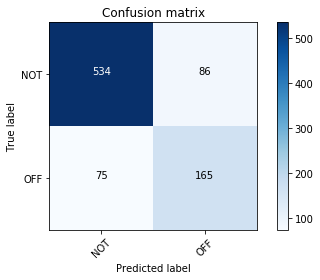

In [749]:
model_subtask_a = model_for_subtask_a(model_parameters_subtask_a)
# build model
model_subtask_a.build_model()
# train
model_subtask_a.train(X_train_task_a, y_train_task_a)
model_subtask_a.evaluate(X_test_task_a, y_test_task_a)

In [753]:
model_parameters_subtask_b = {'epochs': 5,
                        'classes':                          np.unique(dataset_task_b['subtask_b']),
                        'num_classes':                      len(np.unique(dataset_task_b['subtask_b'])),
                        'tokenizer':                        tokenizer_task_b,
                        'vocab_size':                       size_of_vocab_task_b,
                        'optimizer':                       'adam',
                        'rnn_layer_bfter_cnn':              True,
                        'rnn_layer':                       'Bidirectional GRU',
                        'use_pretrained_embedding':         False,
                        'convolutional_layer':              True,
                        'custom_metrics_f1':                False,
                    }

In [754]:
class model_for_subtask_b():
    def __init__(self, model_parameters):
        self.hparams = model_parameters
        if self.hparams['use_pretrained_embedding'] == True:
            self.load_build_embeddings()
    def load_build_embeddings(self):
        print('Load pretrained embedding ...')
        embeddings_index = dict()
        f = open('glove.42B.300d.txt')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        embedding_matrix = np.zeros((self.hparams['vocab_size'], 300))
        
        for word, index in self.hparams['tokenizer'].word_index.items():
            if index > self.hparams['vocab_size'] - 1:
                break
            else:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[index] = embedding_vector    
        
        self.embedding_matrix = embedding_matrix
        
    def build_model(self, optimizer = 'adam'):
        model = Sequential()
        if self.hparams['use_pretrained_embedding'] == True:
            model.add(Embedding(self.hparams['vocab_size'], 300, input_length=50, weights=[self.embedding_matrix], trainable=False))
        else:
            model.add(Embedding(self.hparams['vocab_size'], 100, input_length=50))
        model.add(Bidirectional(GRU(300, return_sequences = True, dropout=0.35, recurrent_dropout=0.35)))
        model.add(Attention(300))
        #model.add(Conv1D(128, 4, activation='relu'))
        #model.add(MaxPooling1D(pool_size=4))
        #model.add(Conv1D(128, 5, activation='relu'))
        #model.add(MaxPooling1D(pool_size=5))
        #model.add(Conv1D(128, 5, activation='relu'))
        #model.add(MaxPooling1D(pool_size=5))
        #model.add(Flatten())
        
        #model.add(LSTM(100, dropout=0.35, recurrent_dropout=0.35))
        #model.add(Bidirectional(LSTM(100, dropout=0.35, recurrent_dropout=0.35)))
        #model.add(GRU(100, dropout=0.35, recurrent_dropout=0.35))
        #model.add(Bidirectional(GRU(100, dropout=0.35, recurrent_dropout=0.35)))
        model.add(Dense(128, activation='relu'))
        #model.add(Flatten())
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        #model.add(Dense(3, activation='softmax'))
        
        self.model = model
        self.model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        #self.model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        model.summary()
        return model
    
    def train(self, X_train_val, y_train_val, computed_weights = None, callbacks = None):
        self.model.fit(X_train_val, y_train_val, validation_split = 0.25, epochs = self.hparams['epochs'], class_weight = computed_weights, callbacks=callbacks)
        
    def evaluate(self, X_test, y_test):
        score = self.model.evaluate(X_test, y_test)
        print('Test accuracy:', score[1])
        
        predictions = self.model.predict(X_test)
        predictions_round = [np.round(x) for x in predictions]
        print(classification_report(y_test, np.array(predictions_round)))
        print("***************8")
        print(f1_score(y_true= (y_test), y_pred=np.array(predictions_round), average='macro'))
        
        def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
            """
            This function prints and plots the confusion matrix.
            """
            
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)
        
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
        cnf_matrix = confusion_matrix(y_test, np.array(predictions_round))
        #cnf_matrix = confusion_matrix(y_test.argmax(axis = 1), np.array(predictions_round).argmax(axis = 1))
        plot_confusion_matrix(cnf_matrix, classes = self.hparams['classes'], title = 'Confusion matrix')
        plt.show()
    

In [683]:
# SMOTE
print("To counter imbalanced dataset: SMOTE Oversampling...")
sm = SMOTE(random_state=12)
X_train_task_b, y_train_task_b = sm.fit_sample(X_train_task_b, y_train_task_b)

To counter imbalanced dataset: SMOTE Oversampling...


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_68 (Embedding)     (None, 50, 100)           866800    
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_107 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_108 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 128)               16512     
__________

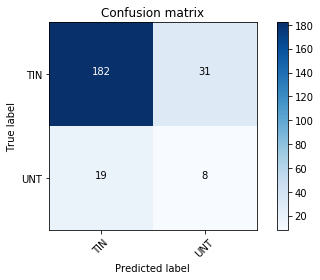

In [696]:
model_subtask_b = model_for_subtask_b(model_parameters_subtask_b)
# build model
model_subtask_b.build_model()
# train
model_subtask_b.train(X_train_task_b, y_train_task_b)
model_subtask_b.evaluate(X_test_task_b, y_test_task_b)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_88 (Embedding)     (None, 50, 100)           866800    
_________________________________________________________________
bidirectional_71 (Bidirectio (None, 50, 600)           721800    
_________________________________________________________________
attention_7 (Attention)      (None, 600)               180350    
_________________________________________________________________
dense_134 (Dense)            (None, 128)               76928     
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 129       
Total params: 1,846,007
Trainable params: 1,846,007
Non-trainable params: 0
_________________________________________________________________


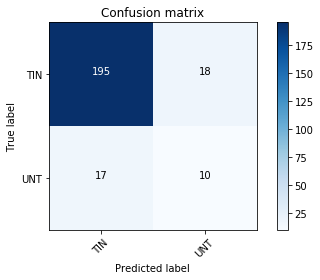

In [755]:
model_subtask_b = model_for_subtask_b(model_parameters_subtask_b)
# build model
model_subtask_b.build_model()
# train
model_subtask_b.train(X_train_task_b, y_train_task_b)
model_subtask_b.evaluate(X_test_task_b, y_test_task_b)

In [759]:
model_parameters_subtask_c = {'epochs': 5,
                        'classes':                          np.unique(dataset_task_c['subtask_c']),
                        'num_classes':                      len(np.unique(dataset_task_c['subtask_c'])),
                        'tokenizer':                        tokenizer_task_c,
                        'vocab_size':                       size_of_vocab_task_c,
                        'optimizer':                       'adam',
                        'rnn_layer_cfter_cnn':              True,
                        'rnn_layer':                       'Bidirectional GRU',
                        'use_pretrained_embedding':         False,
                        'convolutional_layer':              True,
                        'custom_metrics_f1':                False,
                    }

In [635]:
# SMOTE
print("To counter imbalanced dataset: SMOTE Oversampling...")
sm = SMOTE(random_state=12)
X_train_task_c, y_train_task_c = sm.fit_sample(X_train_task_c, y_train_task_c)

To counter imbalanced dataset: SMOTE Oversampling...


7221

In [547]:
y_integers = np.argmax(y_train_task_c, axis=1)
cw = compute_class_weight('balanced', np.unique(y_integers), y_integers)
weights = dict(enumerate(cw))

In [760]:
class model_for_subtask_c():
    def __init__(self, model_parameters):
        self.hparams = model_parameters
        if self.hparams['use_pretrained_embedding'] == True:
            self.load_build_embeddings()
    def load_build_embeddings(self):
        print('Load pretrained embedding ...')
        embeddings_index = dict()
        f = open('glove.42B.300d.txt')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        embedding_matrix = np.zeros((self.hparams['vocab_size'], 300))
        
        for word, index in self.hparams['tokenizer'].word_index.items():
            if index > self.hparams['vocab_size'] - 1:
                break
            else:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[index] = embedding_vector    
        
        self.embedding_matrix = embedding_matrix
        
    def build_model(self, optimizer = 'adam'):
        model = Sequential()
        if self.hparams['use_pretrained_embedding'] == True:
            model.add(Embedding(self.hparams['vocab_size'], 300, input_length=50, weights=[self.embedding_matrix], trainable=False))
        else:
            model.add(Embedding(self.hparams['vocab_size'], 100, input_length=50))
        model.add(Bidirectional(GRU(300, return_sequences = True, dropout=0.35, recurrent_dropout=0.35)))
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=5))
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=5))
        
        
        
        model.add(Flatten())
        #model.add(LSTM(100, dropout=0.35, recurrent_dropout=0.35))
        #model.add(Bidirectional(LSTM(100, dropout=0.35, recurrent_dropout=0.35)))
        #model.add(GRU(100, dropout=0.35, recurrent_dropout=0.35))
        #model.add(Bidirectional(GRU(100, dropout=0.35, recurrent_dropout=0.35)))
        model.add(Dense(128, activation='relu'))
        #model.add(Flatten())
        model.add(Dropout(0.2))
        #model.add(Dense(1, activation='sigmoid'))
        model.add(Dense(3, activation='softmax'))
        
        self.model = model
        #self.model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        self.model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        model.summary()
        return model
    
    def train(self, X_train_val, y_train_val, computed_weights = None, callbacks = None):
        self.model.fit(X_train_val, y_train_val, validation_split = 0.25, epochs = self.hparams['epochs'], class_weight = computed_weights, callbacks=callbacks)
        
    def evaluate(self, X_test, y_test):
        score = self.model.evaluate(X_test, y_test)
        print('Test accuracy:', score[1])
        
        predictions = self.model.predict(X_test)
        predictions_round = [np.round(x) for x in predictions]
        print(classification_report(y_test, np.array(predictions_round)))
        print("***************8")
        print(f1_score(y_true= (y_test), y_pred=np.array(predictions_round), average='macro'))
        
        def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
            """
            This function prints and plots the confusion matrix.
            """
            
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)
        
            fmt = 'd'
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
        #cnf_matrix = confusion_matrix(y_test, np.array(predictions_round))
        cnf_matrix = confusion_matrix(y_test.argmax(axis = 1), np.array(predictions_round).argmax(axis = 1))
        plot_confusion_matrix(cnf_matrix, classes = self.hparams['classes'], title = 'Confusion matrix')
        plt.show()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_90 (Embedding)     (None, 50, 100)           815700    
_________________________________________________________________
bidirectional_73 (Bidirectio (None, 50, 600)           721800    
_________________________________________________________________
conv1d_144 (Conv1D)          (None, 46, 128)           384128    
_________________________________________________________________
max_pooling1d_133 (MaxPoolin (None, 9, 128)            0         
_________________________________________________________________
conv1d_145 (Conv1D)          (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_134 (MaxPoolin (None, 1, 128)            0         
_________________________________________________________________
flatten_56 (Flatten)         (None, 128)               0         
__________

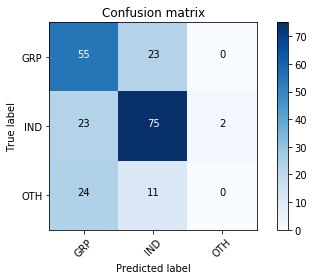

In [761]:
model_subtask_c = model_for_subtask_c(model_parameters_subtask_c)
# build model
model_subtask_c.build_model()
# train
model_subtask_c.train(X_train_task_c, y_train_task_c)
model_subtask_c.evaluate(X_test_task_c, y_test_task_c)

In [ ]:
.reshape((n_samples, -1))
y = digits.target


In [569]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm.libsvm import predict_proba
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.svm import LinearSVC
from scipy import sparse
import numpy as np
import pickle as pkl
from scipy import io
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
import sys

In [ ]:
parameters_to_tune = {'min_samples_split': [2, 4, 6, 10, 15, 25],
                      'min_samples_leaf': [1, 2, 4, 10],
                      'max_depth': [None, 4, 10, 15],
                      'splitter' : ('best', 'random'),
                      'max_features':[None, 2, 4, 6, 8, 10, 12, 14],
                      'class_weight':[{0: w} for w in [1, 2, 4, 6, 10]]}

In [595]:
# Run the classifier
svc = svm.LinearSVC()
pipeline = svc  # Pipeline([('clf', svc)])
param_grid = {'loss': ['hinge', 'squared_hinge'],
                  'random_state': [32391],
                  'C': [0.01, 0.1, 1, 10],
             'class_weight':[{'TIN': w} for w in [1, 2, 4, 6, 8, 10]]}

model = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose=1, cv=5)

model.fit(X_train_task_b, dataset_task_b['subtask_b'][:train_data_task_b_idx])

#predictingY = model.predict(X_test_task_c)

    # Print the results

#print("Model accuracy: ", accuracy_score(y_test_task_c, predictingY))

#print(classification_report(testingDataYnp, predictingY, digits=8))

#print(model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   36.4s finished
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [{'TIN': 1}, {'TIN': 2}, {'TIN': 4},
                                          {'TIN': 6}, {'TIN': 8}, {'TIN': 10}],
                         'loss': ['hinge', 'squared_hinge'],
                         'random_state': [32391]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [596]:
predictingY = model.predict(X_test_task_b)

# Print the results

#print("Model accuracy: ", accuracy_score(y_test_task_c, predictingY))

print(classification_report(dataset_task_b['subtask_b'][train_data_task_b_idx:], predictingY, digits=8))

print(model.best_params_)

              precision    recall  f1-score   support

         TIN  0.87830688 0.77934272 0.82587065       213
         UNT  0.07843137 0.14814815 0.10256410        27

    accuracy                      0.70833333       240
   macro avg  0.47836913 0.46374544 0.46421737       240
weighted avg  0.78832088 0.70833333 0.74449866       240

{'C': 0.01, 'class_weight': {'TIN': 1}, 'loss': 'hinge', 'random_state': 32391}


In [597]:
print(f1_score(y_true= (dataset_task_b['subtask_b'][train_data_task_b_idx:]), y_pred=np.array(predictingY), average='macro'))

0.46421737466513585
